# 9 - Exploration of Historical NBA Players (Part I)
Alright. So we've looked at some of the teams. I have a sense of what a "good team" looks like, and what a "bad team" looks like. Although there is a lot of ground to cover on the intangibles of basketball and watching tape, my initial approach to this was a numbers approach and I will stick to my guns no matter how stupid or misleading it is... ha... ha............. ha.
![](http://www.reactiongifs.com/r/lu.gif)

I mean...
![](http://i.makeagif.com/media/9-28-2015/H8PLvc.gif)

## Pulling Data
To collect the data, I will have to scrape basketball-reference again. They have some pretty cool data:
- For each year, for each player:
    - Per game stats - [http://www.basketball-reference.com/leagues/NBA_2017_per_game.html](http://www.basketball-reference.com/leagues/NBA_2017_per_game.html)
    - Per 36 min stats - [http://www.basketball-reference.com/leagues/NBA_2017_per_minute.html](http://www.basketball-reference.com/leagues/NBA_2017_per_minute.html)
    - Per 100 poss stats - [http://www.basketball-reference.com/leagues/NBA_2017_per_poss.html](http://www.basketball-reference.com/leagues/NBA_2017_per_poss.html)
    - Advanced stats - [http://www.basketball-reference.com/leagues/NBA_2017_advanced.html](http://www.basketball-reference.com/leagues/NBA_2017_advanced.html)
    
When scraping the per-team stats, bball-ref had each team on a separate page with all the seasons listed.

The per-player stats have each season on a separate page, with all the players listed.

Similarly to the per-team stats, I'll just have to do a few loops:
- Loop once for every season (let's stick with our previously determined filter of excluding everything before the 79-80 season because of incomplete stat tracking, and the 98-99 season specifically because of a shortened lock-out season).
    - Within each season, loop through the different pages of types of stats and pull
    
Let's start coding?
![](https://media.giphy.com/media/xTiTnrJ1horNom6RKo/giphy.gif)

In [1]:
# Load libraries & initial config
%matplotlib nbagg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from StringIO import StringIO
import warnings
warnings.filterwarnings('ignore')

In [2]:
import datetime

# Create a dict of the pages I'm out to scrape
playerStatsBaseUrl = 'http://www.basketball-reference.com/leagues/NBA_'
playerStatsUrlSuffix = {
    'perGameStats': '_per_game.html',
    'per36Stats': '_per_minute.html',
    'per100Stats': '_per_poss.html',
    'advancedStats': '_advanced.html'
}

# Create a list of years to scrape through, to the current year
#   Unfortunately, I've been using the start year of a season (e.g. for the 98-99 season, I've been calling that season "1998")
#   basketball-reference uses the latter year as the identifier... I'm going to stick with my own convention, but I will have to
#      use their convention to scrape the pages for now
currentYear = datetime.datetime.now().year
years = range(1980, currentYear + 1)    # Remember that this is the 1979-1980 season to 2016-2017
years.remove(1999)    # Remove the 98-99 lockout season

print years

[1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]


In [3]:
# Iterate through NBA seasons to get player stats
#   1. For each season
#       a. Get different types of stats
#       b. Concatenate stats by rows (horizontally)
#   2. Aggregate stats of all seasons into a single pandas dataframe (vertically)
seasonAggDf = None

for year in years:
    seasonStatsAggDf = None

#     print '\nStarting to scan {}'.format(team)
    for playStatName, playerStatUrl in playerStatsUrlSuffix.iteritems():
        # Format URL to scan
        urlToScan = '{}{}{}'.format(
            playerStatsBaseUrl,
            year,
            playerStatUrl
        )

        # Pull data from HTML table
        #   Notice here we do not make the first row the header because we need that row of data to compare
        #   and drop duplicate headers in the middle of the table
#         print 'Checking {}'.format(urlToScan)
        playerStatsDf = pd.read_html(
            io = urlToScan,
            header = None,
            attrs = {'class': 'stats_table'}
        )[0]

        # Fix some formatting issues (extra header rows in the middle of table) from bball ref
        playerStatsDf = playerStatsDf[playerStatsDf['Player'] != 'Player']
        playerStatsDf.reset_index(inplace = True)

        # Fix some formatting issues (extra columns) from bball ref
        if u' ' in playerStatsDf.columns:
            playerStatsDf.drop(u' ', axis = 1, inplace = True)
        if u' .1' in playerStatsDf.columns:
            playerStatsDf.drop(u' .1', axis = 1, inplace = True)

        # Since we are appending data from multiple tables, we append a prefix to each column table in order to
        #   preserve which columns came frmo which tables
        playerStatsDf.columns = ['{}_{}'.format(str(playStatName).encode('utf-8'), str(col).encode('utf-8')) for col in playerStatsDf.columns]

        # Aggregate stats dataframes
        if seasonStatsAggDf is None:
            seasonStatsAggDf = playerStatsDf
        else:
            seasonStatsAggDf = pd.concat([seasonStatsAggDf, playerStatsDf], axis = 1)

    # Aggregate stats dataframes
    seasonStatsAggDf['season_start_year'] = year - 1
    
    if seasonAggDf is None:
        seasonAggDf = seasonStatsAggDf
    else:
        seasonAggDf = pd.concat([seasonAggDf, seasonStatsAggDf], axis = 0)

    print 'Finished scraping {}'.format(year)

Finished scraping 1980
Finished scraping 1981
Finished scraping 1982
Finished scraping 1983
Finished scraping 1984
Finished scraping 1985
Finished scraping 1986
Finished scraping 1987
Finished scraping 1988
Finished scraping 1989
Finished scraping 1990
Finished scraping 1991
Finished scraping 1992
Finished scraping 1993
Finished scraping 1994
Finished scraping 1995
Finished scraping 1996
Finished scraping 1997
Finished scraping 1998
Finished scraping 2000
Finished scraping 2001
Finished scraping 2002
Finished scraping 2003
Finished scraping 2004
Finished scraping 2005
Finished scraping 2006
Finished scraping 2007
Finished scraping 2008
Finished scraping 2009
Finished scraping 2010
Finished scraping 2011
Finished scraping 2012
Finished scraping 2013
Finished scraping 2014
Finished scraping 2015
Finished scraping 2016
Finished scraping 2017


In [4]:
print seasonAggDf.shape

(18420, 123)


In [5]:
for column in  seasonAggDf.columns:
    print column

perGameStats_index
perGameStats_Rk
perGameStats_Player
perGameStats_Pos
perGameStats_Age
perGameStats_Tm
perGameStats_G
perGameStats_GS
perGameStats_MP
perGameStats_FG
perGameStats_FGA
perGameStats_FG%
perGameStats_3P
perGameStats_3PA
perGameStats_3P%
perGameStats_2P
perGameStats_2PA
perGameStats_2P%
perGameStats_eFG%
perGameStats_FT
perGameStats_FTA
perGameStats_FT%
perGameStats_ORB
perGameStats_DRB
perGameStats_TRB
perGameStats_AST
perGameStats_STL
perGameStats_BLK
perGameStats_TOV
perGameStats_PF
perGameStats_PS/G
per100Stats_index
per100Stats_Rk
per100Stats_Player
per100Stats_Pos
per100Stats_Age
per100Stats_Tm
per100Stats_G
per100Stats_GS
per100Stats_MP
per100Stats_FG
per100Stats_FGA
per100Stats_FG%
per100Stats_3P
per100Stats_3PA
per100Stats_3P%
per100Stats_2P
per100Stats_2PA
per100Stats_2P%
per100Stats_FT
per100Stats_FTA
per100Stats_FT%
per100Stats_ORB
per100Stats_DRB
per100Stats_TRB
per100Stats_AST
per100Stats_STL
per100Stats_BLK
per100Stats_TOV
per100Stats_PF
per100Stats_PTS
per

In [6]:
print seasonAggDf.head()

   perGameStats_index perGameStats_Rk   perGameStats_Player perGameStats_Pos  \
0                   0               1  Kareem Abdul-Jabbar*                C   
1                   1               2         Tom Abernethy               PF   
2                   2               3           Alvan Adams                C   
3                   3               4       Tiny Archibald*               PG   
4                   4               5         Dennis Awtrey                C   

  perGameStats_Age perGameStats_Tm perGameStats_G perGameStats_GS  \
0               32             LAL             82             NaN   
1               25             GSW             67             NaN   
2               25             PHO             75             NaN   
3               31             BOS             80              80   
4               31             CHI             26             NaN   

  perGameStats_MP perGameStats_FG        ...        advancedStats_USG%  \
0            38.3            1

In [13]:
# First, I'll just grab some columns that look useful to me
playerAggDfToAnalyze = seasonAggDf[[
    'season_start_year',
    'perGameStats_Player',
    'perGameStats_Pos',
    'perGameStats_Age',
    'perGameStats_Tm',
    'perGameStats_G',
    'perGameStats_GS',
    'perGameStats_MP',
    'per100Stats_FG',
    'per100Stats_FGA',
    'per100Stats_FG%',
    'per100Stats_3P',
    'per100Stats_3PA',
    'per100Stats_3P%',
    'per100Stats_2P',
    'per100Stats_2PA',
    'per100Stats_2P%',
    'per100Stats_FT',
    'per100Stats_FTA',
    'per100Stats_FT%',
    'per100Stats_ORB',
    'per100Stats_DRB',
    'per100Stats_TRB',
    'per100Stats_AST',
    'per100Stats_STL',
    'per100Stats_BLK',
    'per100Stats_TOV',
    'per100Stats_PF',
    'per100Stats_PTS',
    'per100Stats_ORtg',
    'per100Stats_DRtg',
    'advancedStats_PER',
    'advancedStats_TS%',
    'advancedStats_3PAr',
    'advancedStats_FTr',
    'advancedStats_ORB%',
    'advancedStats_DRB%',
    'advancedStats_TRB%',
    'advancedStats_AST%',
    'advancedStats_STL%',
    'advancedStats_BLK%',
    'advancedStats_TOV%',
    'advancedStats_USG%',
    'advancedStats_OWS',
    'advancedStats_DWS',
    'advancedStats_WS',
    'advancedStats_WS/48',
    'advancedStats_OBPM',
    'advancedStats_DBPM',
    'advancedStats_BPM',
    'advancedStats_VORP'
]]

# Remove spcial characters out of header
playerAggDfToAnalyze.columns = pd.Series(playerAggDfToAnalyze.columns).str.replace('%', 'Perc').str.replace('/', '')

# Convert numeric arguments to numeric
playerAggDfToAnalyze = playerAggDfToAnalyze.apply(lambda x: pd.to_numeric(x, 'ignore'))

print playerAggDfToAnalyze.dtypes

season_start_year          int64
perGameStats_Player       object
perGameStats_Pos          object
perGameStats_Age           int64
perGameStats_Tm           object
perGameStats_G             int64
perGameStats_GS          float64
perGameStats_MP          float64
per100Stats_FG           float64
per100Stats_FGA          float64
per100Stats_FGPerc       float64
per100Stats_3P           float64
per100Stats_3PA          float64
per100Stats_3PPerc       float64
per100Stats_2P           float64
per100Stats_2PA          float64
per100Stats_2PPerc       float64
per100Stats_FT           float64
per100Stats_FTA          float64
per100Stats_FTPerc       float64
per100Stats_ORB          float64
per100Stats_DRB          float64
per100Stats_TRB          float64
per100Stats_AST          float64
per100Stats_STL          float64
per100Stats_BLK          float64
per100Stats_TOV          float64
per100Stats_PF           float64
per100Stats_PTS          float64
per100Stats_ORtg         float64
per100Stat

In [14]:
# Save data to S3 so we can use it for future analysis
csv_buffer = StringIO()
playerAggDfToAnalyze.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object('2017edmfasatb', 'fas_boto/data/playerAggDfToAnalyze20170606.csv').put(Body=csv_buffer.getvalue())

{u'ETag': '"afde41d488f9b3f8ecb14375e052f8a0"',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '0',
   'date': 'Tue, 06 Jun 2017 19:52:33 GMT',
   'etag': '"afde41d488f9b3f8ecb14375e052f8a0"',
   'server': 'AmazonS3',
   'x-amz-id-2': '098JCzWNsyooNwRaujiJLQBhYa1DNk7HPlzALJ8hT3uaz/Owk34Xt3zhMc7KtveeiWtYV/FXNlk=',
   'x-amz-request-id': '73E5DB0D251973D3'},
  'HTTPStatusCode': 200,
  'HostId': '098JCzWNsyooNwRaujiJLQBhYa1DNk7HPlzALJ8hT3uaz/Owk34Xt3zhMc7KtveeiWtYV/FXNlk=',
  'RequestId': '73E5DB0D251973D3',
  'RetryAttempts': 0}}

So we should have the data now in a format where each row represents one player, on one team, per one season. Theoretically if we only look at Kobe Bryan, we should see 18 rows or however many he played.

In [15]:
print playerAggDfToAnalyze[playerAggDfToAnalyze['perGameStats_Player'] == 'Kobe Bryant'].shape[0]

19


Damn... I'm off by one lol. I guess I'm not a true baskeball fan. Let's just do a quick plot of Kobe's points per 100 possessions.

<IPython.core.display.Javascript object>


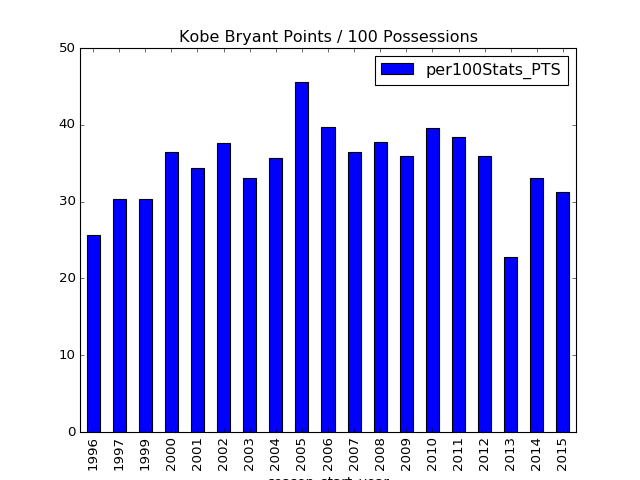

In [16]:
playerAggDfToAnalyze[playerAggDfToAnalyze['perGameStats_Player'] == 'Kobe Bryant'].plot(kind = 'bar', x = 'season_start_year', y = 'per100Stats_PTS', title = 'Kobe Bryant Points / 100 Possessions')

It's kinda interesting. Until I started doing some of this analysis, I honestly never really thought in pace. It makes sense though. A guy who played 4 minutes a game vs 40 minutes a game. They obviously won't have the same output. Kobe's going to score 30 a game while... I dunno... off the top of my head let's say Bruno Caboclo won't usually get more than like 4 if he gets any. This could also be misleading becaues a guy could come on for like 5 minutes and score 5 points. His per 100 possession or per 36 minutes stats would be off the charts. Small sample sizes must beware in these cases.

All this to say that I'm not sure what Kobe's per 100 possessions points should look like... I mean if 100 points per possession is about a game, there's no way Kobe's averaging 45 points on any given season. This would make sense though I guess because Kobe didn't play 48 minutes a game. And remember, the average minutes per game is actually over 48 due to the overtime.

What does your average points per 100 look like?

<IPython.core.display.Javascript object>


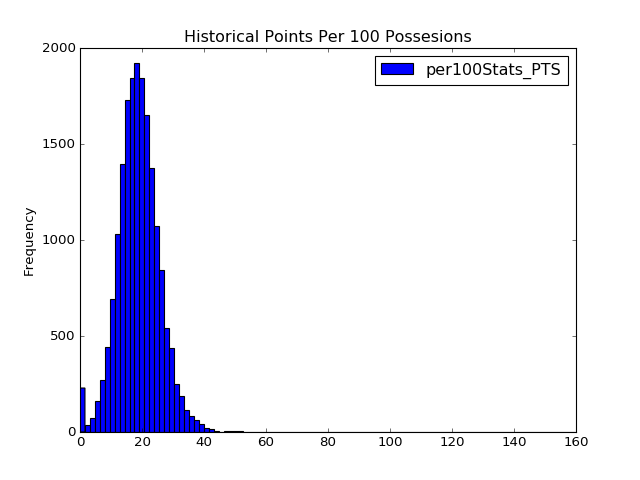

In [17]:
playerAggDfToAnalyze[['per100Stats_PTS']].plot(kind = 'hist', bins = 100, title = 'Historical Points Per 100 Possesions')

Your average player scores about 17 points per 100 possessions. 40 is high. 45 is basically unheard of. I'm going to quickly check some stats about points per 100 possessions. It does look like there's data that goes up to 160 and and also a bunch at 0. I'll just cap it as to not skew some of the stats.

<IPython.core.display.Javascript object>


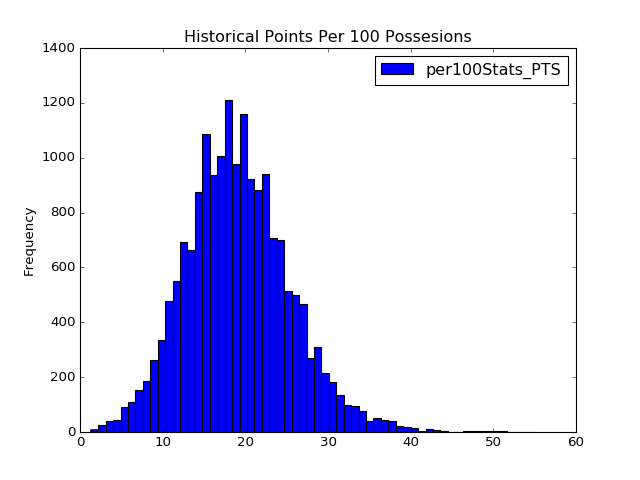

In [18]:
playerAggDfToAnalyze1To60Pts = playerAggDfToAnalyze[(playerAggDfToAnalyze['per100Stats_PTS'] > 1) & (playerAggDfToAnalyze['per100Stats_PTS'] < 60)]
playerAggDfToAnalyze1To60Pts[['per100Stats_PTS']].plot(kind = 'hist', bins = 60, title = 'Historical Points Per 100 Possesions')

In [ ]:
playerAggDfToAnalyze1To60Pts[['per100Stats_PTS']].describe()

I was wrong, the average is about 19 points (maybe the higher values were skewing the stats before). 19 points with a ~6.5 point deviation. That means 95% of the data exists within 19 +/- 13 points. 6 to 32 points. Kobe averaged... **WHAT** for a season? 45? Jesus christ... That's 26 points, or basically 4 standard deviations above the mean, good for 99.99th percentile throughout history. GOOD JOB KOBE. That was the season I assume where he had like 7 straight 40 games in a row. Beasting.

I know DeMar's doing good right now, just for calibration, what is his points per 100?

<IPython.core.display.Javascript object>


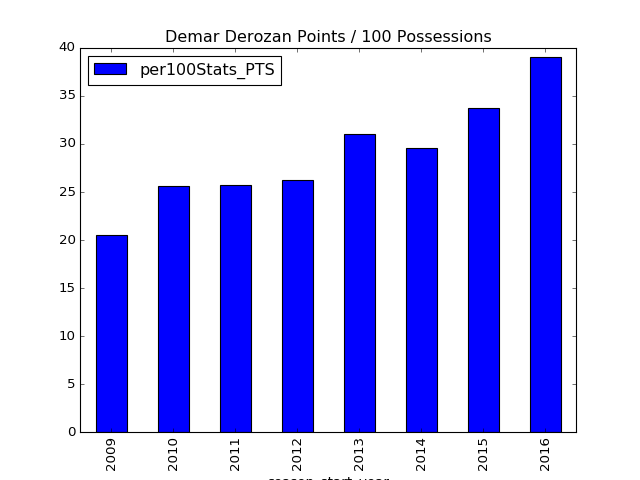

In [19]:
playerAggDfToAnalyze[playerAggDfToAnalyze['perGameStats_Player'] == 'DeMar DeRozan'].plot(kind = 'bar', x = 'season_start_year', y = 'per100Stats_PTS', title = 'Demar Derozan Points / 100 Possessions')

He's getting up there man... almost 40. Essentially 3 standard deviations above the mean. Still insanely efficient scoring.

Okay, honestly, I just wanted to check a few numbers just to see the data wasn't mangled. It looks good (for now). I can already see a few situations where I might have to clean the data a bit further, e.g. players who were traded mid-season show up twice within a season because each row is one player per **one team** per one season. But this honestyl depends on the situation in which I'm looking at the data in, so I will leave this for now and save this dataset to S3 to access later.

In the next post, I'll be trying to explore this data a bit further from a birds eye view to gain some insights.

<IPython.core.display.Javascript object>


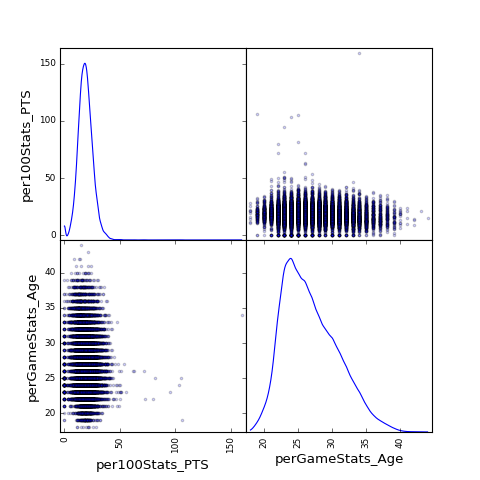

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001076FAC8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000CEAE5F8>]], dtype=object)

In [20]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(playerAggDfToAnalyze[[
    'per100Stats_PTS',
    'perGameStats_Age'
]], alpha=0.2, figsize=(6, 6), diagonal='kde')